# Notebook for the Project

## Introduction

Do MNIST-1D, compare CNN, RandomForest with PCA, LinearRegression with PCA

Goal: Compare the relation of accuracy to training and prediction time.
Expected outcome: CNN is the most accurate, but will be a lot slower than the others.

## Dependencies

In [1]:
# !pip install torch
# !pip install pandas
# !pip install scikit-learn
# !pip install tensorboard
# !pip install seaborn
# !pip install torchvision

## Imports

In [2]:
import torch
from torch import autograd
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
from copy import deepcopy

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter
import sklearn.metrics as metrics
from pandas import Series
from typing import Union
import json
from sklearn.metrics import confusion_matrix, accuracy_score


from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

/Users/veikko/Documents/Kouluhommia/MachineLearning/aalto-machine-learning/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [3]:

def optimize_sklearn(X_train, y_train, model, random_grid, hparam_max_evals, metric, kfolds=5, mode="random"):
    # Inspiration from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    # First create the base model to tune
    # Random search of parameters, using k-fold cross validation, 
    # search across 100 different combinations, and use all available cores
    if mode=="random":
        model_opt = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = hparam_max_evals, cv = kfolds, verbose=0, random_state=42, n_jobs = -1)
    elif mode=="grid":
        model_opt = GridSearchCV(estimator = model, param_grid = random_grid, cv = kfolds, verbose=0, n_jobs = -1)
    else:
        raise ValueError(f"Unknown mode {mode}")

    # Fit the random search model
    model_opt.fit(X_train, y_train)
    return model_opt
    



def train(train_loader, model, optimizer, criterion, device, detect_bad_gradients=False, clip_grad_norm=False):
    """
    Trains PyTorch modelfor one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        model: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0

    model.train()

    # Iterate through batches
    for i, data in enumerate(train_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move data to target device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Compute RMSE from MSE
        if detect_bad_gradients:
            with autograd.detect_anomaly():
                loss.backward()
        else:
            loss.backward()
        if clip_grad_norm:
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)  # Clip gradients
        optimizer.step()

        # Keep track of loss (MSE) and r2
        avg_loss += torch.sqrt(loss)

    return avg_loss / len(train_loader)


def test(test_loader, model, criterion, device):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        model: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0

    model.eval()

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():

        # Iterate through batches
        all_predictions = []
        all_labels = []

        for data in test_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move data to target device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, labels))  # Compute RMSE from MSE

            all_predictions.extend(outputs.detach().numpy())
            all_labels.extend(labels.detach().numpy())

            # Keep track of loss (MSE) and r2
            avg_loss += loss

    return avg_loss / len(test_loader)
      # Track the average loss and the r2 of the last batch




def run_torch(model, train_set, val_set, test_set, log_comment="", log_hparams=False, writer=None, **config):
    """
    Run a test
    """
    try:
        if writer is None:
            # Create a writer to write to Tensorboard
            writer = SummaryWriter(comment=log_comment)
            writer.add_text("run_params", json.dumps(config, indent=2))

        # Create the dataloaders
        train_loader = DataLoader(
            train_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, persistent_workers=False
        )
        val_loader = DataLoader(
            val_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, persistent_workers=False
        )
        test_loader = DataLoader(
            test_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, persistent_workers=False
        )

        # Create loss function and optimizer
        if config["loss"] == "MSE" or config["loss"] == "RMSE":
            criterion = nn.MSELoss()
        else:
            raise ValueError(f"Loss {config['loss']} not recognized.")

        optimizer = torch.optim.Adam(
            model.parameters(), lr=config["optimizer"]["lr"], weight_decay=config["optimizer"]["weight_decay"]
        )
        if config["lr_scheduler"]:
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, **config["lr_scheduler"])

        # Use GPU if available
        device = "cuda" if torch.cuda.is_available() else "cpu"

        model = model.to(device)

        patience = config.get("early_stopping_patience", torch.inf)
        best_model = None
        best_loss = np.inf
        counter = 0

        print("Starting initial training")
        for epoch in tqdm(range(config["epochs"])):
            # Train on data
            train_loss = train(
                train_loader, model, optimizer, criterion, device, config["detect_bad_gradients"]
            )
            # After training set eval mode on
            model.eval()
            # Test on data
            val_loss = test(val_loader, model, criterion, device)
            test_loss = test(test_loader, model, criterion, device)

            if config["lr_scheduler"]:
                scheduler.step()

            # Write metrics to Tensorboard
            writer.add_scalars("Loss", {"Train_loss": train_loss, "Val_loss": val_loss, "Test_loss": test_loss}, epoch)

            if log_hparams:

                report_metrics = {
                    "hparam/test_loss": test_loss,
                    "hparam/train_loss": train_loss,
                }
                writer.add_hparams(log_hparams, report_metrics, run_name=log_comment)

            # Early stopping
            if best_loss > val_loss.detach().numpy():
                best_loss = val_loss.detach().numpy()
                counter = 0
                best_model = deepcopy(model)
            else:
                counter += 1
                if counter > patience:
                    print("Initiating early stopping")
                    if best_model is not None:
                        print("Restoring best weights")
                        model = best_model
                    break

        print("\nTraining Finished.")
        writer.flush()
        writer.close()

        # Finally, use the model to predict the train, validation and test sets
    except KeyboardInterrupt:
        print("Interrupted")
    print("Gathering final predictions")

    if not log_hparams:
        results, predictions, model = gather_results(model, train_loader, val_loader, test_loader)

        return results, predictions, model
    else:
        return


def gather_results(model, train_loader, val_loader, test_loader):
    """
    Gather the results for train, val and test sets.
    Returns:
        results, predictions, model
    """
    model.eval()
    with torch.no_grad():

        y_train = []
        y_pred_train = []

        y_val = []
        y_pred_val = []

        y_test = []
        y_pred_test = []

        for data in train_loader:
            inputs, labels = data
            pred = model(inputs)
            y_train.extend(labels.detach().numpy().flatten())
            y_pred_train.extend(pred.detach().numpy().flatten())

        # Iterate through batches
        for data in val_loader:
            inputs, labels = data
            pred = model(inputs)
            y_val.extend(labels.detach().numpy().flatten())
            y_pred_val.extend(pred.detach().numpy().flatten())

        for data in test_loader:
            inputs, labels = data
            pred = model(inputs)
            y_test.extend(labels.detach().numpy().flatten())
            y_pred_test.extend(pred.detach().numpy().flatten())

    y_pred_train = np.array(y_pred_train)
    y_pred_val = np.array(y_pred_val)
    y_pred_test = np.array(y_pred_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    train_res = classification_report(y_train, y_pred_train)
    validation_res = classification_report(y_val, y_pred_val)
    test_res = classification_report(y_test, y_pred_test)

    results = pd.DataFrame({"train": train_res, "validate": validation_res, "test": test_res})

    predictions = {
        "train": {"y": y_train, "pred": y_pred_train},
        "validate": {"y": y_val, "pred": y_pred_val},
        "test": {"y": y_test, "pred": y_pred_test},
    }

    return results, predictions, model

## Load the data

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_data = MNIST('./data', train=True, download=True, transform=transform)
test_data = MNIST('./data', train=False, download=True, transform=transform)

## Study the MNIST-2D dataset

Length of the dataset

In [5]:
print("Lenght of the training set:", len(train_data))
print("Lenght of the test set:", len(test_data))
print()
print("Shape of \"features\", i.e. images: ", train_data[0][0].shape)

Lenght of the training set: 60000
Lenght of the test set: 10000

Shape of "features", i.e. images:  torch.Size([1, 28, 28])


### Show some example images

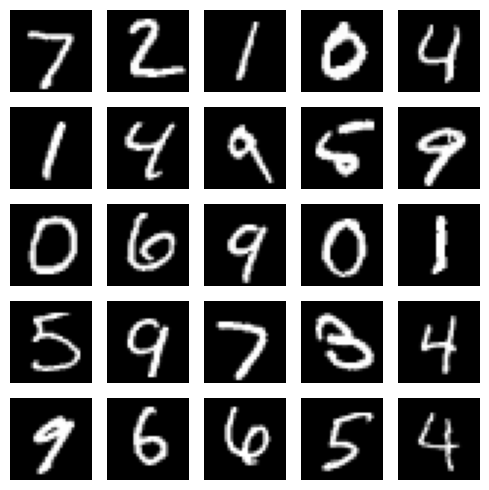

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, _ = test_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Distribution of labels in train and test sets

train_labels = [train_data[i][1] for i in range(len(train_data))]
test_labels = [test_data[i][1] for i in range(len(test_data))]

test_features = torch.stack([test_data[i][0] for i in range(len(test_data))])
train_features = torch.stack([train_data[i][0] for i in range(len(train_data))])

train_labels = pd.DataFrame({"label": train_labels, "dataset": "train"}) 
test_labels = pd.DataFrame({"label": test_labels, "dataset": "test"}) 

<AxesSubplot: xlabel='label', ylabel='Percent'>

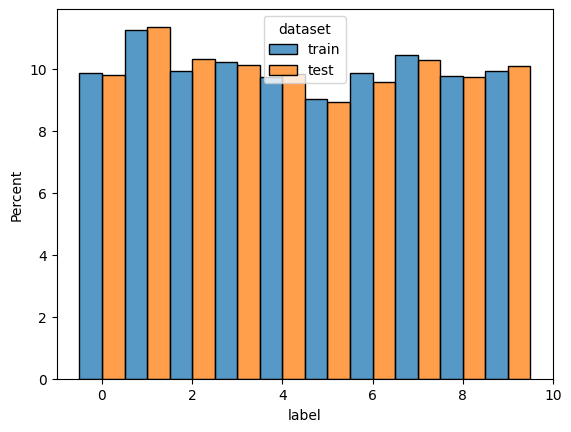

In [8]:
labels = pd.concat([train_labels, test_labels], axis=0)
sns.histplot(
    data=labels, 
    x="label", 
    hue="dataset", 
    multiple="dodge", 
    stat="percent",
    discrete=True,
    common_norm=False,
    )

In [9]:
print("Feature statistics")
print("Min:", train_features.min())
print("Max:", train_features.max())
print("Mean:", train_features.mean())
print("Std:", train_features.std())

Feature statistics
Min: tensor(-0.4242)
Max: tensor(2.8215)
Mean: tensor(-0.0001)
Std: tensor(1.0000)


The data is normalized correctly as we see.

## Visualize the pixel distributions in training set

Text(0.5, 1.0, 'Pixelwise median difference')

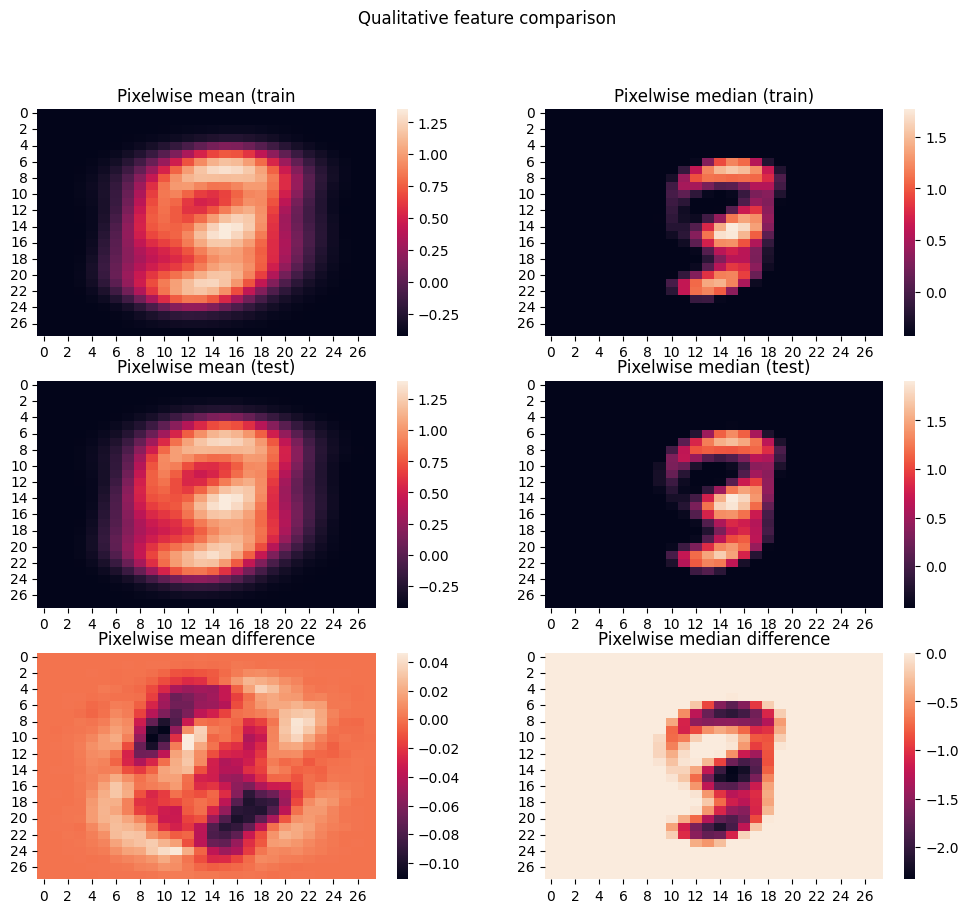

In [10]:
fig,axs = plt.subplots(3,2, figsize=(12,10))
plt.suptitle("Qualitative feature comparison")
sns.heatmap(train_features.mean(dim=0)[0], ax=axs[0,0])
axs[0, 0].set_title("Pixelwise mean (train")
sns.heatmap(np.median(train_features.detach().numpy(), axis=0)[0], ax=axs[0,1])
axs[0, 1].set_title("Pixelwise median (train)")
sns.heatmap(test_features.mean(dim=0)[0], ax=axs[1,0])
axs[1,0].set_title("Pixelwise mean (test)")
sns.heatmap(np.median((test_features).detach().numpy(), axis=0)[0], ax=axs[1,1])
axs[1,1].set_title("Pixelwise median (test)")
sns.heatmap(train_features.mean(dim=0)[0] - test_features.mean(dim=0)[0], ax=axs[2,0])
axs[2,0].set_title("Pixelwise mean difference")
sns.heatmap(np.median(train_features.detach().numpy()) - np.median((test_features).detach().numpy(), axis=0)[0], ax=axs[2,1])
axs[2,1].set_title("Pixelwise median difference")

## Feature engineering

For the more traditional models in comparison, the total number of input features 28x28 = 784 is significantly high, and PCA is used to reduce the features

In [11]:
train_set_flat = train_features.flatten(start_dim=-2).squeeze()
test_set_flat = test_features.flatten(start_dim=-2).squeeze()
train_set_flat.shape, test_set_flat.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

### PCA Elbow Curve

Text(0, 0.5, 'Explained variance')

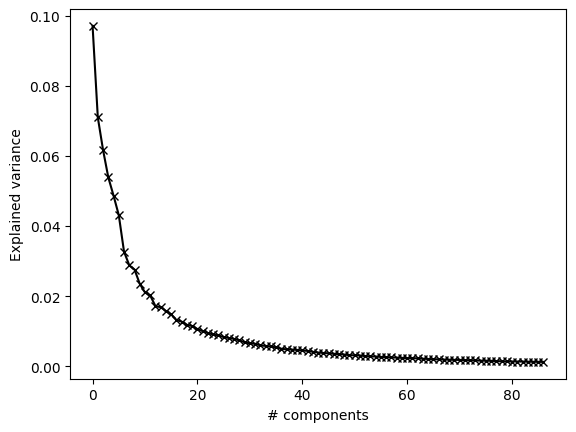

In [12]:
pca = PCA(0.9)
pca.fit(train_set_flat)
plt.plot(pca.explained_variance_ratio_, 'k-x')
plt.xlabel("# components")
plt.ylabel("Explained variance")

We can see that the curve begins to flatten out after 20 components, let's use that.

## Logistic Regression Model

Train accuracy 0.8753166666666666
Test accuracy 0.8807


Text(0.5, 80.7222222222222, 'Predicted')

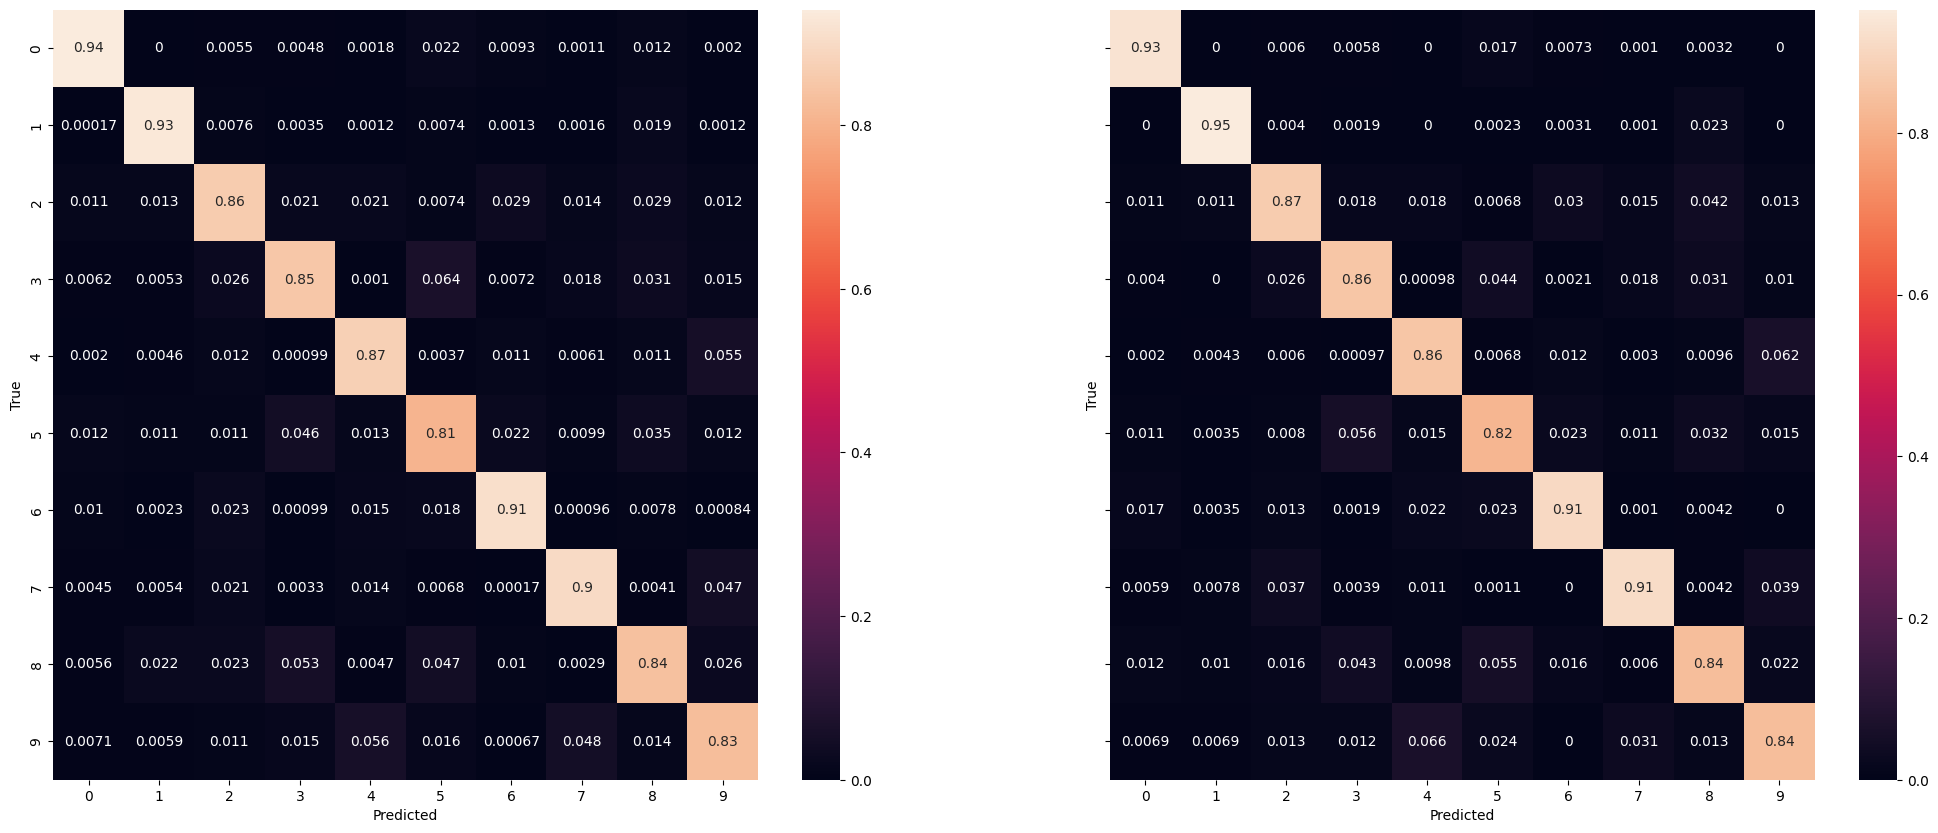

In [22]:
model = Pipeline(
    [
    ("pca", PCA(n_components=20)),
    ("reg", LogisticRegression(multi_class='multinomial', solver="sag", fit_intercept=True, max_iter=500)) # Cross-entropy loss
    ]
)
X_train = train_set_flat
y_train = train_labels["label"]

X_test = test_set_flat
y_test = test_labels["label"]

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Additional
print("Train accuracy", accuracy_score(y_train, y_pred_train))
print("Test accuracy", accuracy_score(y_test, y_pred_test))

fig, axs = plt.subplots(1,2, figsize=(25, 10), sharex=True, sharey=True)
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize="pred"),  annot=True, ax=axs[0])
axs[0].set_ylabel("True")
axs[0].set_xlabel("Predicted")
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize="pred"), annot=True, ax=axs[1])
axs[1].set_ylabel("True")
axs[1].set_xlabel("Predicted")

### Logistic Regression Optimization

Optimize the strength of l2 regularisation

In [14]:
# Regularization strength
C = np.logspace(-1,1, 10)
# Choice of penalty
penalty = ["l2"]
# Create the random grid
random_grid = {
    'penalty': penalty,
    'C': C,
    "solver": ["sag"] # Sag solver is faster
}

pca = PCA(n_components=20)
model = LogisticRegression(multi_class="multinomial", max_iter=1000)
hparam_cv_pca = optimize_sklearn(
    pca.fit_transform(X_train), 
    y_train, 
    model=model, 
    random_grid=random_grid,
    hparam_max_evals=20, 
    metric="neg_accuracy_score", 
    kfolds=5, 
    mode="grid"
    )

,mean_test_score,mean_fit_time
count,10.000,10.000
mean,0.873,11.888
std,0.000,0.717
min,0.873,10.443
25%,0.873,11.531
50%,0.873,11.811
75%,0.873,12.251
max,0.873,12.870


<AxesSubplot: xlabel='param_C', ylabel='mean_test_score'>

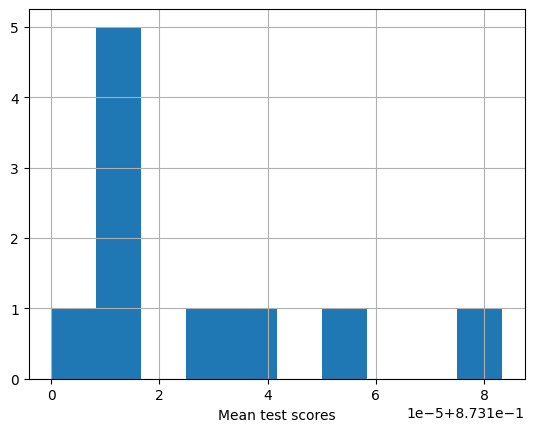

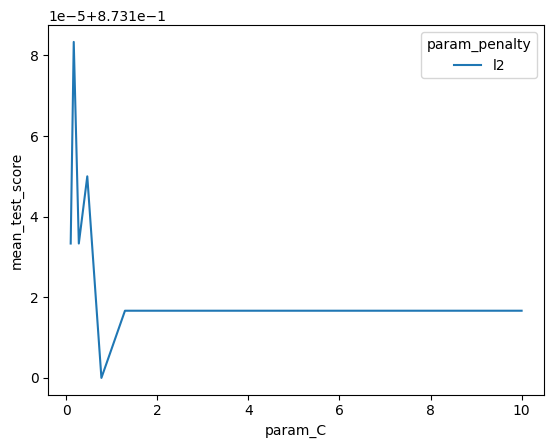

In [15]:
hparam_data = pd.DataFrame(hparam_cv_pca.cv_results_)
display(hparam_data[["mean_test_score", "mean_fit_time"]].describe().round(3))
hparam_data["mean_test_score"].hist()
plt.xlabel("Mean test scores")
plt.figure()
sns.lineplot(data=hparam_data, x="param_C", y="mean_test_score", hue="param_penalty", estimator="mean")

### Results with optimized model

Train accuracy 0.8749166666666667
Test accuracy 0.8805


Text(0.5, 80.7222222222222, 'Predicted')

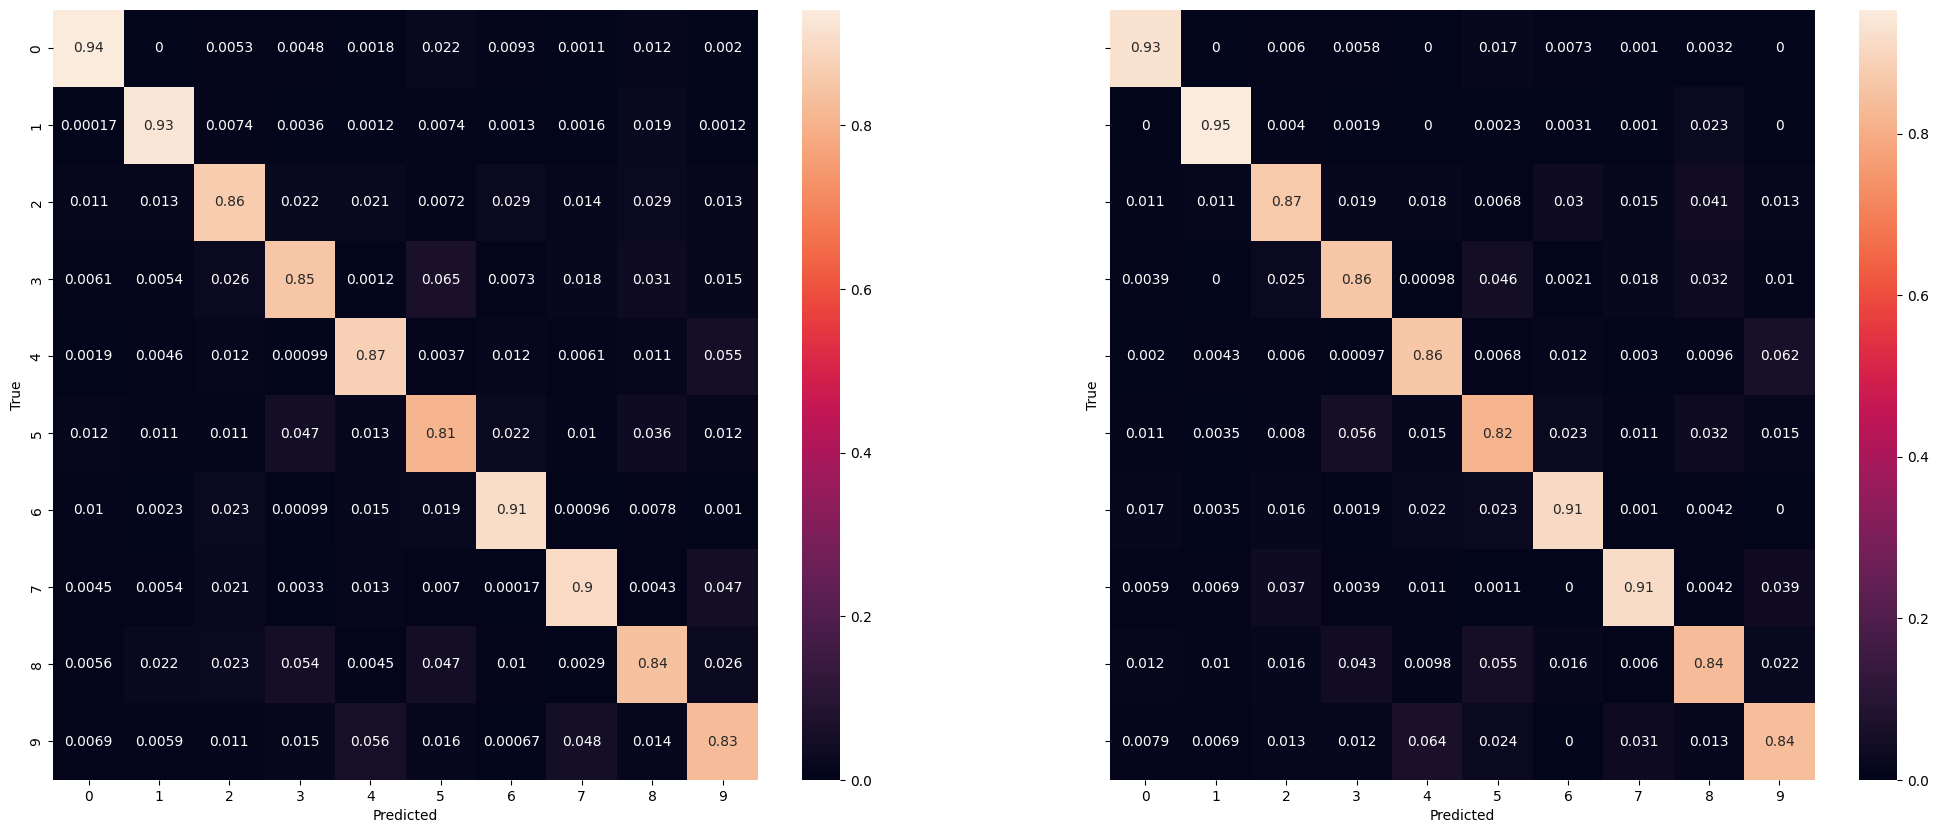

In [16]:
model = Pipeline(
    [
    ("pca", PCA(n_components=20)),
    ("reg", LogisticRegression(multi_class="multinomial", max_iter=1000).set_params(**hparam_cv_pca.best_params_)) # Cross-entropy loss
    ]
)

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Additional
print("Train accuracy", accuracy_score(y_train, y_pred_train))
print("Test accuracy", accuracy_score(y_test, y_pred_test))

fig, axs = plt.subplots(1,2, figsize=(25, 10), sharex=True, sharey=True)
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize="pred"),  annot=True, ax=axs[0])
axs[0].set_ylabel("True")
axs[0].set_xlabel("Predicted")
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize="pred"), annot=True, ax=axs[1])
axs[1].set_ylabel("True")
axs[1].set_xlabel("Predicted")


We see that the model hardly benefitted from the optimisation and can considered it optimal for the logistic regression model space.

## Decision Tree

Note: As only the training data is used in the randomized hyperparameter search cross validation, it can be considered as using a separate train-val-test split, in which the train and validation sets are used to optimize the model and the test set is used only for testing to avoid overfitting by hyperparameter optimization.

In [17]:
# Number of features to consider at every split
max_features = np.linspace(0.33, 1.0, 5)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {
    "criterion": ["log_loss", "gini"],
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}
model = DecisionTreeClassifier()
hparam_cv = optimize_sklearn(X_train, y_train,random_grid=random_grid,model=model, hparam_max_evals=10, metric="neg_accuracy_score", kfolds=3) # Due to computational limitation use 3-fold

,mean_test_score,mean_fit_time
count,10.000,10.000
mean,0.825,9.224
std,0.056,3.597
min,0.675,5.109
25%,0.823,6.076
50%,0.840,8.455
75%,0.859,12.857
max,0.861,13.937


<AxesSubplot: xlabel='param_max_depth', ylabel='mean_fit_time'>

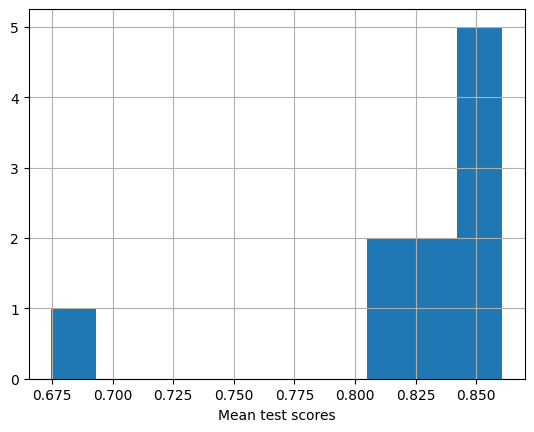

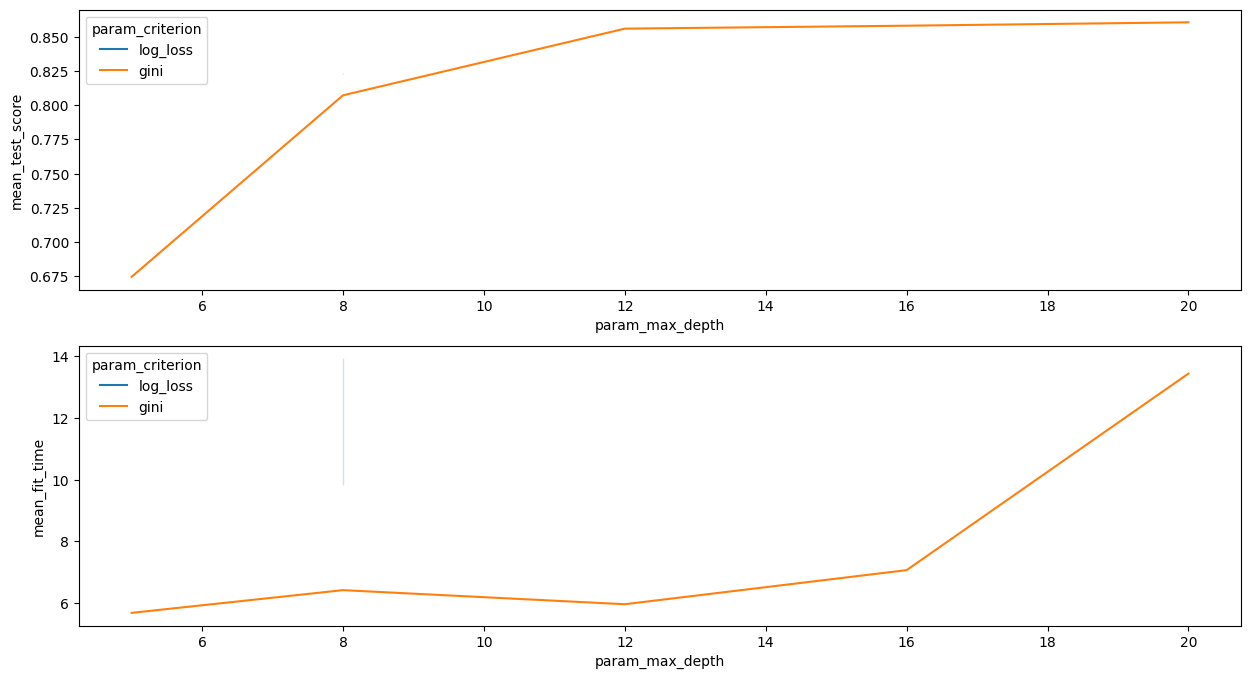

In [18]:
hparam_data = pd.DataFrame(hparam_cv.cv_results_)
display(hparam_data[["mean_test_score", "mean_fit_time"]].describe().round(3))
hparam_data["mean_test_score"].hist()
plt.xlabel("Mean test scores")
fig, axs = plt.subplots(2,1, figsize=(15,8))
sns.lineplot(data=hparam_data, x="param_max_depth", y="mean_test_score",hue="param_criterion", estimator="mean", ax=axs[0])
sns.lineplot(data=hparam_data, x="param_max_depth", y="mean_fit_time",hue="param_criterion", estimator="mean", ax=axs[1])

Apply the PCA to speed up the training and allow for more iterations and try again.

In [19]:
pca = PCA(n_components=20)
model = DecisionTreeClassifier()
hparam_cv_pca = optimize_sklearn(pca.fit_transform(X_train), y_train,model=model, random_grid=random_grid,hparam_max_evals=40, metric="neg_accuracy_score", kfolds=5) # Due to computational limitation use 3-fold

,mean_test_score,mean_fit_time
count,40.000,40.000
mean,0.775,2.141
std,0.091,1.165
min,0.534,0.282
25%,0.744,1.174
50%,0.823,1.913
75%,0.838,3.062
max,0.848,5.099


mean_fit_time                                         \
                        count      mean      std       min       25%   
param_criterion                                                        
gini                      6.0  8.708990  3.78990  5.681404  6.075536   
log_loss                  4.0  9.997352  3.68145  5.108841  8.659714   

                                                 mean_test_score            \
                       50%        75%        max           count      mean   
param_criterion                                                              
gini              6.742394  11.848200  13.684362             6.0  0.819342   
log_loss         10.471714  11.809352  13.937139             4.0  0.832412   

                                                                             
                      std       min       25%       50%       75%       max  
param_criterion                                                              
gini             0.073804  0.674650  0.819458  0.857058  0.859071  0.860617  
log_loss         0.018397  0.822617  0.823229  0.823517  0.832700  0.860000

<AxesSubplot: xlabel='param_max_depth', ylabel='mean_fit_time'>

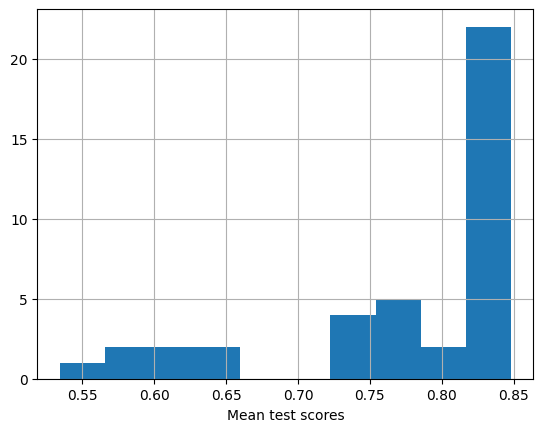

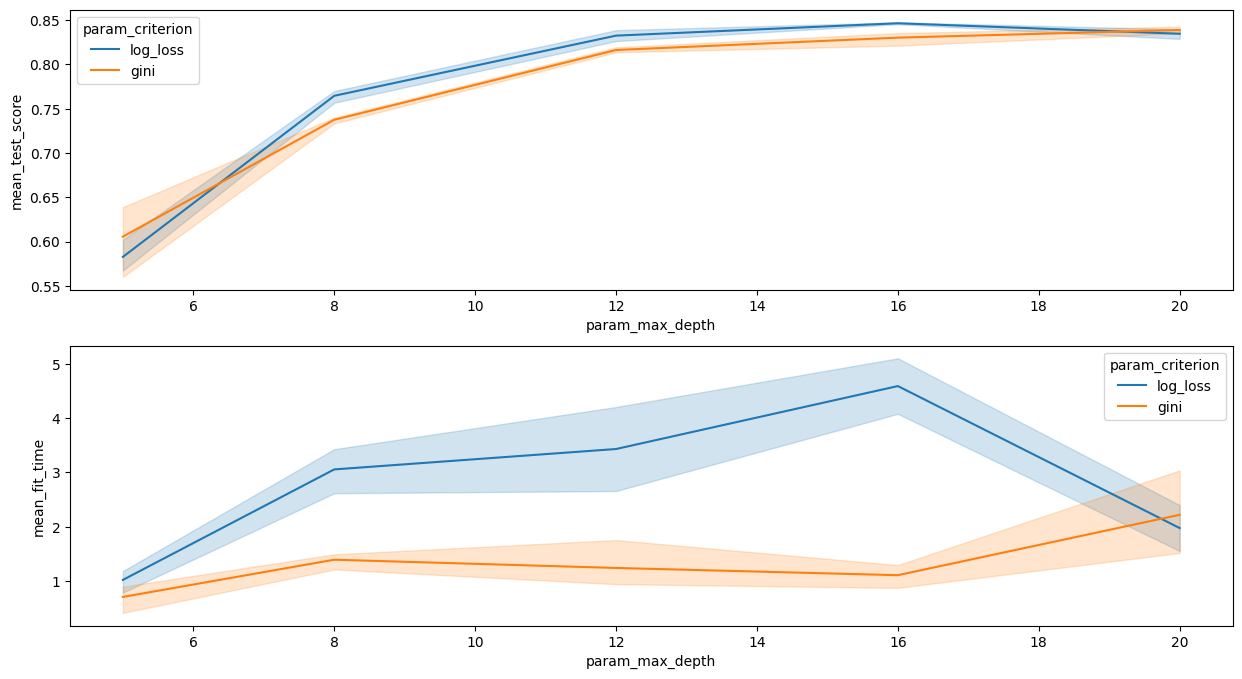

In [20]:
hparam_data_pca = pd.DataFrame(hparam_cv_pca.cv_results_)
display(hparam_data_pca[["mean_test_score", "mean_fit_time"]].describe().round(3))
display(hparam_data.groupby("param_criterion").describe()[["mean_fit_time", "mean_test_score"]])
hparam_data_pca["mean_test_score"].hist()
plt.xlabel("Mean test scores")
fig, axs = plt.subplots(2,1, figsize=(15,8))
sns.lineplot(data=hparam_data_pca, x="param_max_depth", y="mean_test_score",hue="param_criterion", estimator="mean", ax=axs[0])
sns.lineplot(data=hparam_data_pca, x="param_max_depth", y="mean_fit_time",hue="param_criterion", estimator="mean", ax=axs[1])

As we can see the performance did decrease slightly with the PCA. Let us find the optimal number of components for the tree.

In [21]:
# Number of features to consider at every split
max_features = [hparam_cv_pca.best_params_["max_features"]]
# Maximum number of levels in tree
max_depth = [hparam_cv_pca.best_params_["max_depth"]]
# Minimum number of samples required to split a node
min_samples_split = [hparam_cv_pca.best_params_["min_samples_split"]]
# Minimum number of samples required at each leaf node
min_samples_leaf = [hparam_cv_pca.best_params_["min_samples_leaf"]]
# Create the random grid
random_grid = {
    "pca__n_components": [15, 20, 25, 30],
    "tree__criterion": ["gini"],
    'tree__max_features': max_features,
    'tree__max_depth': max_depth,
    'tree__min_samples_split': min_samples_split,
    'tree__min_samples_leaf': min_samples_leaf
}

pca = PCA()
model = Pipeline([("pca", pca),("tree", DecisionTreeClassifier())])

hparam_cv_pca = optimize_sklearn(X_train, y_train, model=model, random_grid=random_grid, metric="neg_accuracy_score",mode="grid", kfolds=5) 

TypeError: optimize_sklearn() missing 1 required positional argument: 'hparam_max_evals'

,mean_test_score,mean_fit_time
count,4.000,4.000
mean,0.838,9.156
std,0.002,1.428
min,0.836,7.955
25%,0.837,7.967
50%,0.838,8.928
75%,0.839,10.118
max,0.839,10.811


<AxesSubplot: xlabel='param_pca__n_components', ylabel='mean_fit_time'>

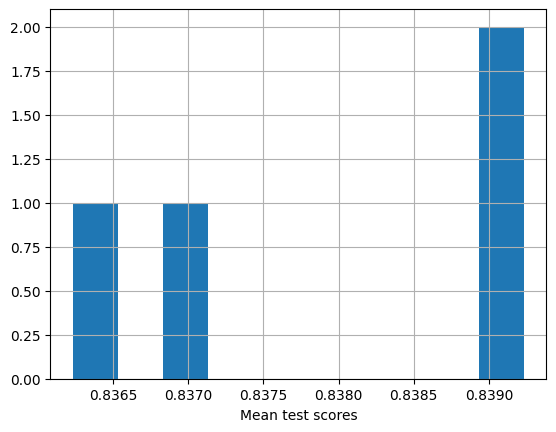

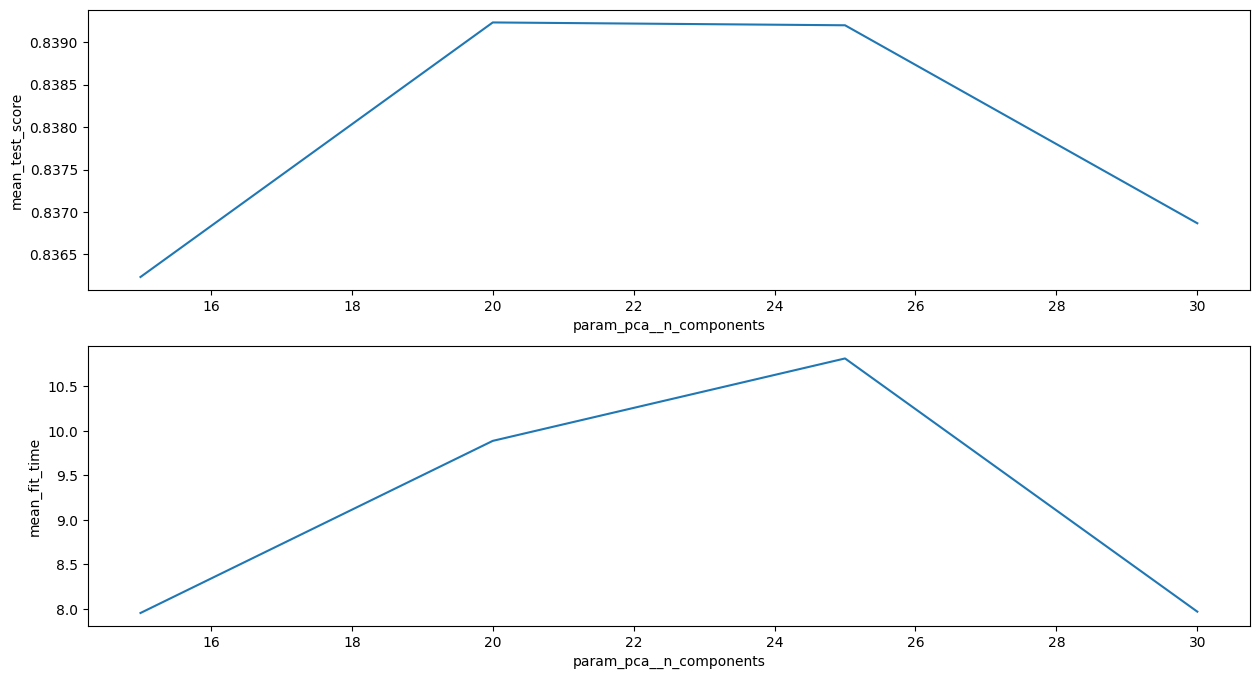

In [ ]:
hparam_data_pca = pd.DataFrame(hparam_cv_pca.cv_results_)
display(hparam_data_pca[["param_pca__n_components", "mean_test_score", "mean_fit_time"]].describe().round(3))
hparam_data_pca["mean_test_score"].hist()
plt.xlabel("Mean test scores")
fig, axs = plt.subplots(2,1, figsize=(15,8))
sns.lineplot(data=hparam_data_pca, x="param_pca__n_components", y="mean_test_score", estimator="mean", ax=axs[0])
sns.lineplot(data=hparam_data_pca, x="param_pca__n_components", y="mean_fit_time", estimator="mean", ax=axs[1])

We can see that the 20 components strikes a balance between the performance and the training time

### Decision Tree Full Training Set test

Train accuracy 0.9689166666666666
Test accuracy 0.852


<AxesSubplot: >

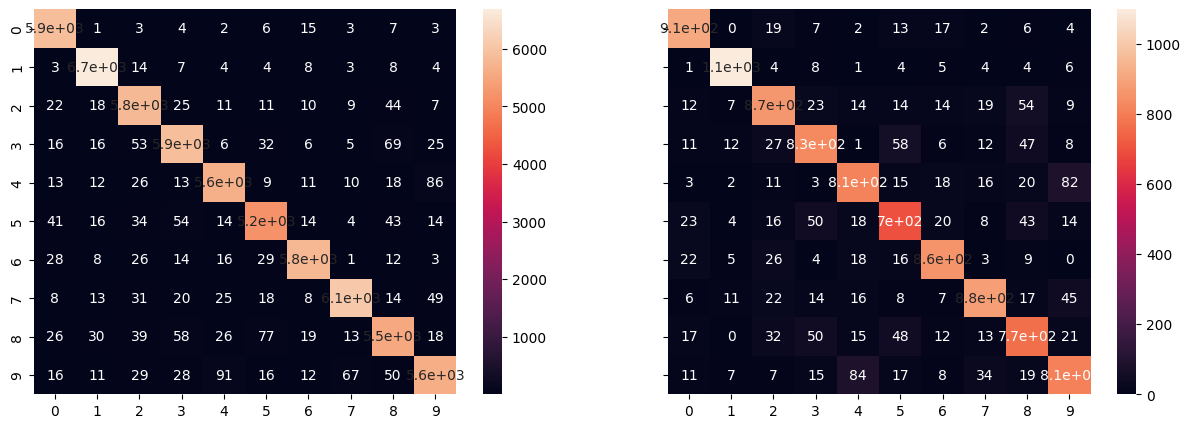

In [ ]:
model_dt = Pipeline(
    [
    ("pca", PCA(n_components=20)),
    ("clf", DecisionTreeClassifier(max_depth=30).set_params(**hparam_cv.best_params_ ))
    ]
)
model_dt.fit(X_train, y_train)
y_pred_train = model_dt.predict(X_train)
y_pred_test = model_dt.predict(X_test)

# Additional
print("Train accuracy", accuracy_score(y_train, y_pred_train))
print("Test accuracy", accuracy_score(y_test, y_pred_test))

fig, axs = plt.subplots(1,2, figsize=(15, 5), sharex=True, sharey=True)
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, ax=axs[0])
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, ax=axs[1])

While the test score is slightly lower than with logistic regression, we can see that the more complex model is able to overfit into the training data. This information could also hint that the model can achieve higher test scores with higher regularization.

## KMeans

Let us see if the classes are separable in the latent space

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
kmeans = KMeans(n_clusters=10) # 1 for each label

pipeline = Pipeline(
    [
    ("pca", pca),
    ("kmeans", kmeans)
    ]
    )

cluster_labels = pipeline.fit_predict(X_train)

pca_X = pca.fit_transform(X_train)

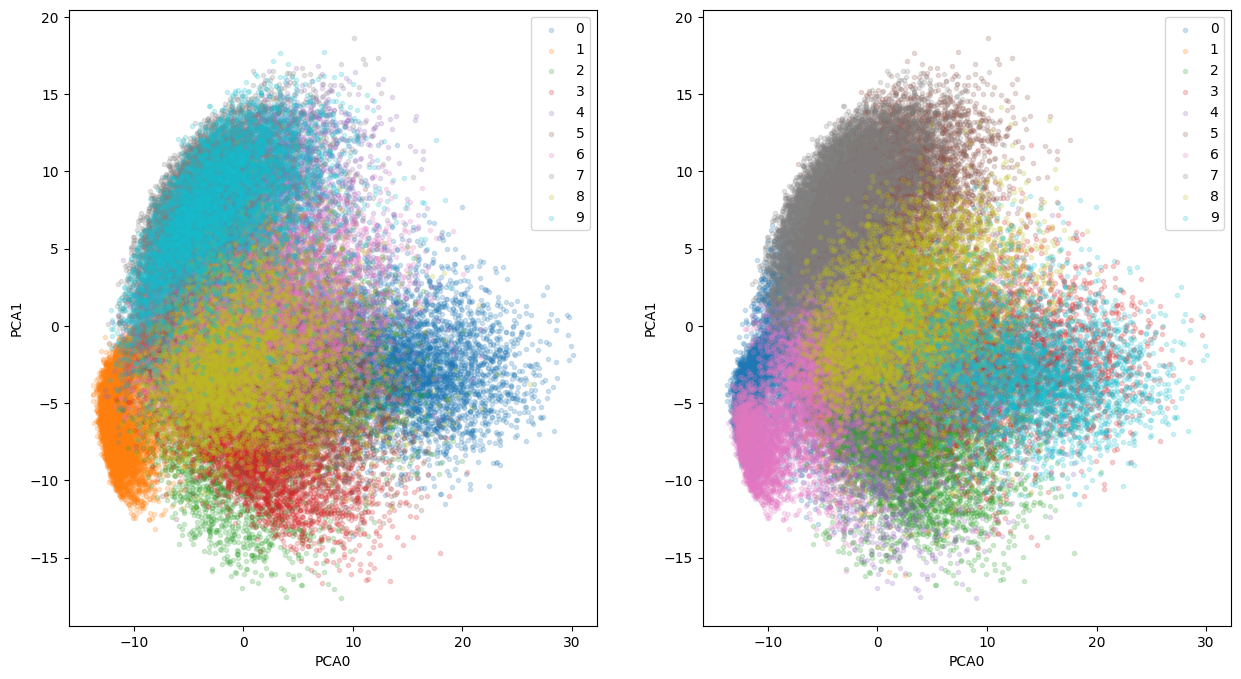

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8))
for i in range(10):
    mask = y_train == i
    axs[0].scatter(pca_X[mask, 0], pca_X[mask,1], label=i, marker=".", alpha=.2)
    axs[0].legend()
for i in range(10):
    mask = cluster_labels == i
    axs[1].scatter(pca_X[mask, 0], pca_X[mask,1], label=i, marker=".", alpha=.2)
    axs[1].legend()

for ax in axs:
    ax.set_xlabel("PCA0")
    ax.set_ylabel("PCA1")

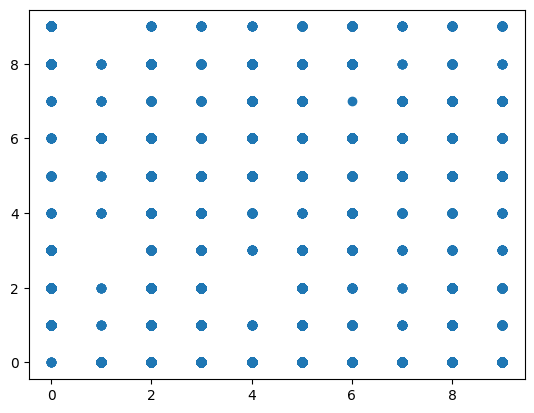

In [ ]:
plt.scatter(y_train, cluster_labels)

...while similar clusters can be seen, no inference can be made directly on the cluster assignment

## PCA Reconstruction

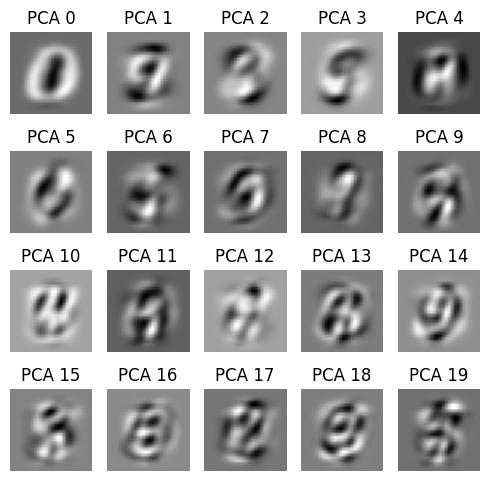

In [ ]:
pca = PCA(n_components=20).fit(X_train)

fig, axs = plt.subplots(4, 5, figsize=(5, 5))
for i in range(20):
    pixel_weights = pca.components_[i,:]
    ax = axs[i // 5][i % 5]
    ax.imshow(pixel_weights.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
    ax.set_title(f"PCA {i}")
plt.tight_layout()
plt.show()

In [ ]:
pca.components_.shape

(20, 784)